# AUS2200 cross section 

This example is based on https://unidata.github.io/MetPy/latest/examples/cross_section.html

In this notebook we will show you how to:

- Open data from the AUS2200 simulation post-processed output
- Extract the variables needed in this notebook
- Use Metpy to calculate the extra variables and the cross-section

You will need to figure out youself:

- How to use this data to create a cross-section plot.

### Load the libraries

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# Metpy library
import metpy.calc as mpcalc
from metpy.interpolate import cross_section
from metpy.units import units

In [2]:
# Let's load Dask to make Xarray more efficient
import dask.distributed as dsk

# Start client
clnt = dsk.Client()
clnt

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38899 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38899/status,
Dashboard: /proxy/38899/status,Workers: 2
Total threads: 2,Total memory: 9.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43801,Workers: 2
Dashboard: /proxy/38899/status,Total threads: 2
Started: Just now,Total memory: 9.00 GiB
Comm: tcp://127.0.0.1:41147,Total threads: 1
Dashboard: /proxy/46749/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40211,


- Dask speeds up analysis of the data, some of these files are quite big.
- You can find task on the toolbar on the left.
- Enter /proxy/8787/status (or whatever dashboard you are given) as the url.
- Using the 'Progress' window lets you see what tasks are happening when you run a command.

## Access data

We extracted some of the variables for pressure levels and saved them in single field files. The files are in the folder:<br>
<br>/scratch/v45/dr4292/pressure_levels/<br>

The available variables on pressure levels are:<br>

- air_temp
- height
- specific_humidity
- u_component_of_wind
- v_component_of_wind
- w_component_of_wind

Lets open all these varibales into 1 dataset for a specific time:

In [3]:
datadir = '/scratch/v45/dr4292/pressure_levels/'
onpress = '*_on_pressure_levels_20220222T1000.nc'

In [ ]:
ds = xr.open_mfdataset(f'{datadir}/{onpress}', chunks={'time': '200mb'}, parallel=True)
# It's good to set chunk size when opening data so Xarray/Dask is more efficient.
# the setting above makes sure we are using chunksizes ~200MB of size which is optimal for dask.

# If you want to do timeseries type operations you might want to specify the chunks as:
# chunks = {'time':-1, 'latitude': '200MB}
# In this way all timesteps for a single cell grid will be in the same chunk

In [5]:
ds

<xarray.Dataset>
Dimensions:              (latitude: 2120, longitude: 2600, time: 1,
                          pressure_level: 19)
Coordinates:
  * latitude             (latitude) float32 -48.79 -48.77 ... -6.852 -6.832
  * longitude            (longitude) float32 107.5 107.5 107.6 ... 159.0 159.0
  * time                 (time) datetime64[ns] 2022-02-22T11:00:00
  * pressure_level       (pressure_level) float32 100.0 500.0 ... 9.25e+04 1e+05
Data variables:
    air_temperature      (time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(1, 19, 2120, 2600), meta=np.ndarray>
    specific_humidity    (time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(1, 19, 2120, 2600), meta=np.ndarray>
    upward_air_velocity  (time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(1, 19, 2120, 2600), meta=np.ndarray>
    x_wind               (time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(1, 19, 2120, 2600), meta=np.ndarray>
    y_wind               (time, pressure_level, latitude, longitude) float32 dask.array<chunksize=(1, 19, 2120, 2600), meta=np.ndarray>

## Calculate cross section 

In [8]:
# Taken from metpy cross section example

# use MetPy’s CF parsing to get the data ready for use
data = ds.metpy.parse_cf()

#Define start/end latitude and longitude points (you can find these in ds above):
start = (-48.788, 107.52)
end = (-6.831799, 158.9802)

#Get the cross section, and convert lat/lon to supplementary coordinates:
cross = cross_section(data, start, end).set_coords(('latitude', 'longitude'))
print(cross)

<xarray.Dataset>
Dimensions:              (time: 1, pressure_level: 19, index: 100)
Coordinates:
  * time                 (time) datetime64[ns] 2022-02-22T11:00:00
  * pressure_level       (pressure_level) float32 100.0 500.0 ... 9.25e+04 1e+05
    metpy_crs            object Projection: latitude_longitude
    longitude            (index) float64 107.5 108.3 109.2 ... 158.3 158.6 159.0
    latitude             (index) float64 -48.79 -48.52 -48.24 ... -7.322 -6.832
  * index                (index) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Data variables:
    air_temperature      (time, pressure_level, index) float32 dask.array<chunksize=(1, 19, 100), meta=np.ndarray>
    specific_humidity    (time, pressure_level, index) float32 dask.array<chunksize=(1, 19, 100), meta=np.ndarray>
    upward_air_velocity  (time, pressure_level, index) float32 dask.array<chunksize=(1, 19, 100), meta=np.ndarray>
    x_wind               (time, pressure_level, index) float32 dask.array<chunksize=(1, 19

- We will be plotting potential temperature, relative humidity, and tangential/normal winds. And so, we need to calculate those, and add them to the dataset.

In [9]:
# Calculate potential temperature and assign the correct units:
cross['Potential_temperature'] = mpcalc.potential_temperature(
    cross['pressure_level'] * units.kPa,
    cross['air_temperature'] * units.kelvin
    )
# Calculate Relative humidity and assign the correct units:
cross['Relative_humidity'] = mpcalc.relative_humidity_from_specific_humidity(
    cross['pressure_level'] * units.kPa,
    cross['air_temperature'] * units.kelvin,
    cross['specific_humidity']/1000
    )
#calculate t_wind and n_wind and assign the correct units:
cross['x_wind'] = cross['x_wind'] * units.knots
cross['y_wind'] = cross['y_wind'] * units.knots
cross['t_wind'], cross['n_wind'] = mpcalc.cross_section_components(
    cross['x_wind'],
    cross['y_wind']
     )

print(cross)

<xarray.Dataset>
Dimensions:                (time: 1, pressure_level: 19, index: 100)
Coordinates:
  * time                   (time) datetime64[ns] 2022-02-22T11:00:00
  * pressure_level         (pressure_level) float32 100.0 500.0 ... 1e+05
    metpy_crs              object Projection: latitude_longitude
    longitude              (index) float64 107.5 108.3 109.2 ... 158.6 159.0
    latitude               (index) float64 -48.79 -48.52 ... -7.322 -6.832
  * index                  (index) int64 0 1 2 3 4 5 6 ... 93 94 95 96 97 98 99
Data variables:
    air_temperature        (time, pressure_level, index) float32 dask.array<chunksize=(1, 19, 100), meta=np.ndarray>
    specific_humidity      (time, pressure_level, index) float32 dask.array<chunksize=(1, 19, 100), meta=np.ndarray>
    upward_air_velocity    (time, pressure_level, index) float32 dask.array<chunksize=(1, 19, 100), meta=np.ndarray>
    x_wind                 (time, pressure_level, index) float32 <Quantity(da...
    y_wind   

## Plot

NB: Again this is copied and pasted as it is in the link at the top of this notebook.

Now we need to use all these variables to create the cross-section plot. So far it only works down to line 13, but it will plot a nice cross-section of the relative humidity. It is now up to you to figure it out!

KeyError: 'x'

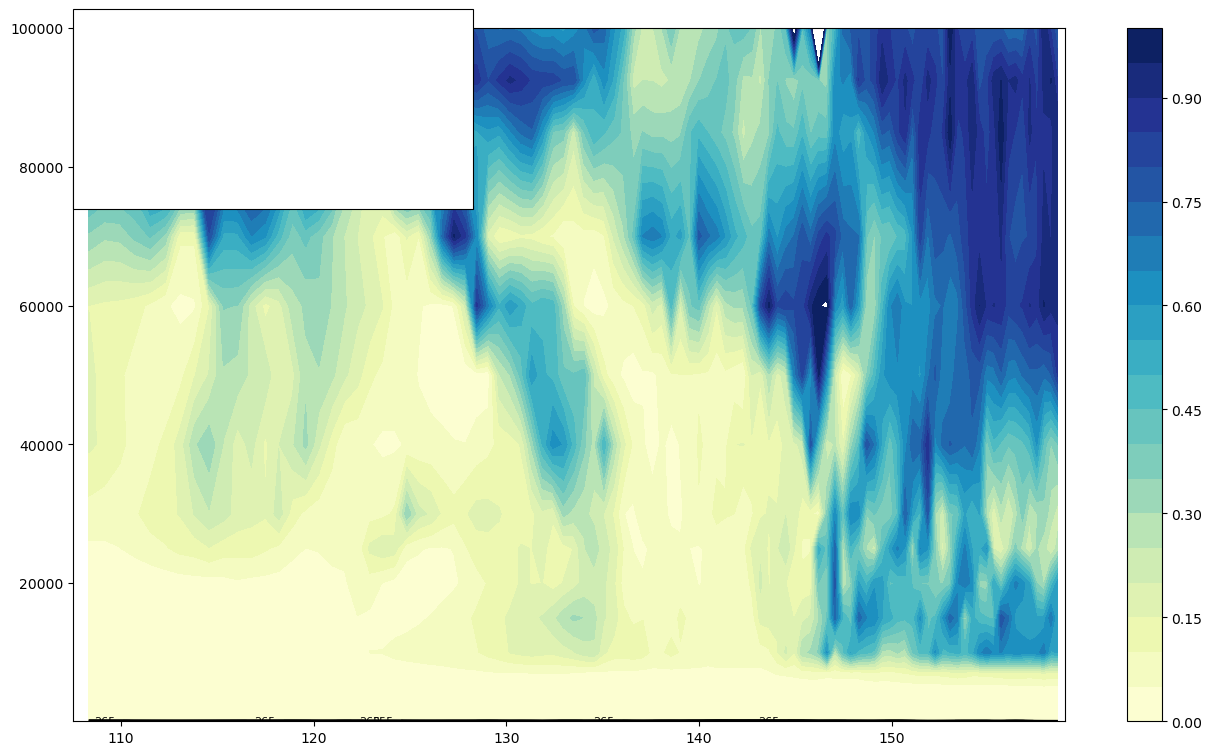

In [16]:
# Define the figure object and primary axes
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()

# Plot RH using contourf
rh_contour = ax.contourf(cross['longitude'], cross['pressure_level'], cross['Relative_humidity'][:,0,:],
                         levels=np.arange(0, 1.05, .05), cmap='YlGnBu')
rh_colorbar = fig.colorbar(rh_contour)

# Plot potential temperature using contour, with some custom labeling
theta_contour = ax.contour(cross['longitude'], cross['pressure_level'], cross['Potential_temperature'][:,0,:],
                           levels=np.arange(250, 450, 5), colors='k', linewidths=2)
theta_contour.clabel(theta_contour.levels[1::2], fontsize=8, colors='k', inline=1,
                     inline_spacing=8, fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot winds using the axes interface directly, with some custom indexing to make the barbs
# less crowded
wind_slc_vert = list(range(0, 19, 2))
wind_slc_horz = slice(5, 100, 5)
ax.barbs(cross['longitude'][wind_slc_horz], cross['pressure_level'][wind_slc_vert],
         cross['t_wind'][wind_slc_vert, wind_slc_horz],
         cross['n_wind'][wind_slc_vert, wind_slc_horz], color='k')

# Adjust the y-axis to be logarithmic
ax.set_yscale('symlog')
ax.set_yticklabels(np.arange(1000, 50, -100))
ax.set_ylim(cross['pressure_level'].max(), cross['pressure_level'].min())
ax.set_yticks(np.arange(1000, 50, -100))

# Define the CRS and inset axes
data_crs = data['pressure_level'].metpy.cartopy_crs
ax_inset = fig.add_axes([0.125, 0.665, 0.25, 0.25], projection=data_crs)

# Plot geopotential height at 500 hPa using xarray's contour wrapper
ax_inset.contour(data['x'], data['y'], data['pressure_level'].sel(isobaric=500.),
                 levels=np.arange(5100, 6000, 60), cmap='inferno')

# Plot the path of the cross section
endpoints = data_crs.transform_points(ccrs.Geodetic(),
                                      *np.vstack([start, end]).transpose()[::-1])
ax_inset.scatter(endpoints[:, 0], endpoints[:, 1], c='k', zorder=2)
ax_inset.plot(cross['x'], cross['y'], c='k', zorder=2)

# Add geographic features
ax_inset.coastlines()
ax_inset.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='k', alpha=0.2, zorder=0)

# Set the titles and axes labels
ax_inset.set_title('')
ax.set_title(f'NARR Cross-Section \u2013 {start} to {end} \u2013 '
             f'Valid: {cross["time"].dt.strftime("%Y-%m-%d %H:%MZ").item()}\n'
             'Potential Temperature (K), Tangential/Normal Winds (knots), Relative Humidity '
             '(dimensionless)\nInset: Cross-Section Path and 500 hPa Geopotential Height')
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel('Longitude (degrees east)')
rh_colorbar.set_label('Relative Humidity (dimensionless)')

plt.show()